# Deep Learning Model 

In [29]:
# Libraries

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import random
import pickle

#from PIL import Image
# !pip install mat73
import mat73
import helper

#import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

### Parameters

In [2]:
resize = 0.2

## Image loading and preprocessing

In [3]:
### Load each file independently (to avoid memory overflows) and retriev PID
patient_ids_dict = dict()
label_ids_dict = dict()
shape_x_dict = dict()
shape_y_dict = dict()
image_dict = dict()

for file_number in range(1,3047):
    file = f'../data/brain-tumor-data-public/{file_number}.mat'
    data_dict = mat73.loadmat(file)
    patient_ids_dict[file_number] = data_dict['cjdata']['PID']
    label_ids_dict[file_number] = int(data_dict['cjdata']['label'])
    shape_x_dict[file_number] = data_dict['cjdata']['image'].shape[0]
    shape_y_dict[file_number] = data_dict['cjdata']['image'].shape[1]
    image_dict[file_number] = data_dict['cjdata']['image']

In [4]:
patient_ids = pd.Series(patient_ids_dict)
label_ids = pd.Series(label_ids_dict)
shape_x = pd.Series(shape_x_dict)
shape_y = pd.Series(shape_y_dict)
image = pd.Series(image_dict)

patients = pd.DataFrame({'pid':patient_ids, 'label':label_ids,
                         'x':shape_x, 'y':shape_y, 'image':image}, index=range(1, 3047))

In [5]:
patients['image'] = patients['image'].apply(lambda x : helper.imx_preproc(x, zero_up_to_one=True, resize=resize))
patients['image'] = patients['image'].apply(lambda x : x.astype('float32'))

## Train and Validation Sets

In [6]:
random.seed(1234)

val_size = 0.2
test_size = 0.2
# Training set has 2436 images test set has 610 images 
train_set, test_set = train_test_split(patients, stratify=patients['label'], test_size=test_size)
# Training set has 1948 images, validation set has 488 images
train_set, val_set = train_test_split(train_set, stratify=train_set['label'], test_size=val_size)

n_total_train = train_set.shape[0]

train_set_x = np.stack(train_set['image'].values)
train_set_y = np.array(train_set['label'])

val_set_x = np.stack(val_set['image'].values)
val_set_y = np.array(val_set['label'])

test_set_x = np.stack(test_set['image'].values)
test_set_y = np.array(test_set['label'])

Applying one hot encoding to target variable y 

In [7]:
new_train_set_y = tf.one_hot(train_set_y, depth = 4)
new_train_set_y = np.array(new_train_set_y)[:,1:]

In [8]:
new_val_set_y = tf.one_hot(val_set_y, depth = 4)
new_val_set_y = np.array(new_val_set_y)[:,1:]

## CNN Implementation

In [9]:
batch_size = 64
IMG_H = int(round(512 * resize, 0))
IMG_W = int(round(512 * resize, 0))

In [10]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 1)),
    
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')
    Dense(3, activation='softmax')
])

CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0

In [11]:
optimizer = 'adam'

In [12]:
# Compile: Define training parameters
CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train model
EPOCHS = 10
BATCHES = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, new_train_set_y, steps_per_epoch=BATCHES,
                       epochs=EPOCHS, validation_data=(val_set_x, new_val_set_y))

Epoch 1/10
30/30 [==============================] - 28s 907ms/step - loss: 0.8495 - accuracy: 0.6155 - val_loss: 0.7011 - val_accuracy: 0.6783
Epoch 2/10
30/30 [==============================] - 26s 852ms/step - loss: 0.6348 - accuracy: 0.7192 - val_loss: 0.5507 - val_accuracy: 0.7439
Epoch 3/10
30/30 [==============================] - 27s 895ms/step - loss: 0.5363 - accuracy: 0.7644 - val_loss: 0.4580 - val_accuracy: 0.7910
Epoch 4/10
30/30 [==============================] - 25s 845ms/step - loss: 0.4462 - accuracy: 0.8080 - val_loss: 0.4144 - val_accuracy: 0.8299
Epoch 5/10
30/30 [==============================] - 24s 811ms/step - loss: 0.3817 - accuracy: 0.8321 - val_loss: 0.3329 - val_accuracy: 0.8586
Epoch 6/10
30/30 [==============================] - 24s 793ms/step - loss: 0.2886 - accuracy: 0.8799 - val_loss: 0.3174 - val_accuracy: 0.8914
Epoch 7/10
30/30 [==============================] - 24s 808ms/step - loss: 0.2327 - accuracy: 0.9086 - val_loss: 0.2895 - val_accuracy: 0.8873

### Results

In [16]:
model_id = 'mcv_1'

#### Summary

In [17]:
with open(f'../results/resize_{resize}/{model_id}_summary.txt', 'w') as f:

    CNN.summary(print_fn=lambda x: f.write(x + '\n'))
    f.close()

#### Hyperparameters

In [38]:
with open(f"../results/resize_{resize}/{model_id}_extended_summary.txt","w") as f:
    aux = CNN.get_config()
    aux['optimizer'] = optimizer
    aux['epoch'] = EPOCHS
    aux['batches'] = BATCHES
    f.write(str(aux))
    f.close()

#### Epoch convergence

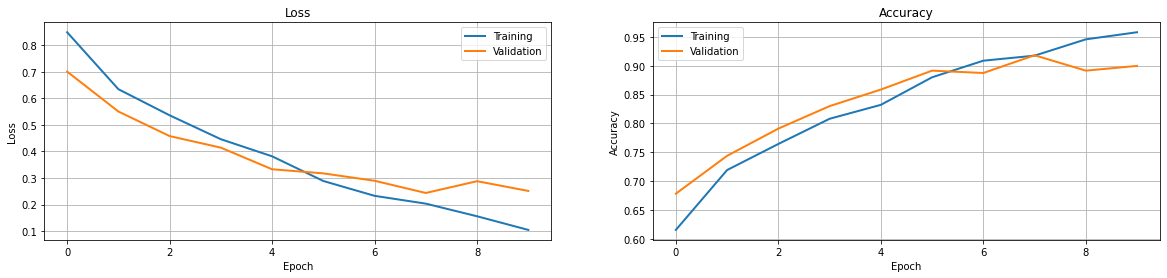

In [22]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(CNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(CNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.savefig(f'../results/resize_{resize}/{model_id}_epochs.png', bbox_inches = 'tight')
plt.show()

#### Confusion Matrix

In [23]:
predictions = CNN.predict(test_set_x)
predictions = predictions.argmax(1) + 1

cm = confusion_matrix(test_set_y, predictions)

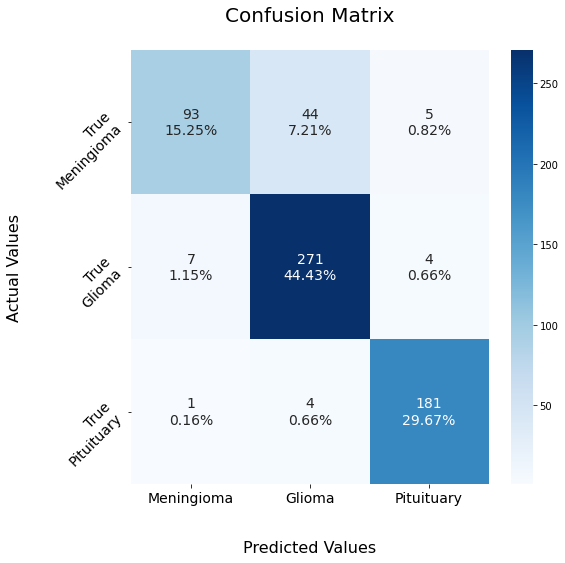

In [25]:
fig, ax = plt.subplots(figsize = (8,8))

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     (np.matmul(cm, np.diag(1/cm.sum(1)))).flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cm,
                 annot=labels, 
                 fmt='',
                 cmap='Blues',
                 annot_kws = {'fontsize':14})

ax.set_title('Confusion Matrix\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', labelpad = 18, fontsize = 16)
ax.set_ylabel('Actual Values', labelpad = 20, fontsize = 16);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Meningioma','Glioma', 'Pituituary'], fontsize = 14)
ax.yaxis.set_ticklabels(['True\nMeningioma','True\nGlioma', 'True\nPituituary'], fontsize = 14, rotation = 45)

## Display the visualization of the Confusion Matrix.
plt.savefig(f'../results/resize_{resize}/{model_id}_confusion_matrix.png', bbox_inches = 'tight')
plt.show()

#### Pickle file

In [30]:
CNN.save(f'../results/resize_{resize}/{model_id}_model.h5')